# Functional `pyiron_atomistics`

In [1]:
from pyiron_workflow import Workflow
from atomistics.calculators.wrapper import as_task_dict_evaluator

## Nodes

In [2]:
@as_task_dict_evaluator
def evaluate_with_lammps(structure, tasks, potential_dataframe):
    import os
    import shutil
    from pyiron_atomistics.lammps.lammps import lammps_function
    results = {}
    path_lmp_calculation = os.path.abspath("lmp_working_directory")
    if os.path.exists(path_lmp_calculation):
        shutil.rmtree(path_lmp_calculation)
    if "calc_energy" in tasks:
        shell_output, parsed_output, job_crashed = lammps_function(
            working_directory=path_lmp_calculation,
            structure=structure,
            potential=potential_dataframe,
        )
        return {"energy": parsed_output["generic"]["energy_tot"][-1]}
    else:
        raise ValueError("The LAMMPS calculator does not implement:", tasks)
    return results

In [3]:
@Workflow.wrap.as_function_node
def get_bulk_structure(element): 
    from ase.build import bulk
    return bulk(element, cubic=True)

In [4]:
@Workflow.wrap.as_function_node
def generate_structures(structure, vol_range, num_points):
    from atomistics.workflows.evcurve.helper import generate_structures_helper
    return generate_structures_helper(
        structure=structure, 
        vol_range=vol_range, 
        num_points=num_points,
    )

In [5]:
@Workflow.wrap.as_function_node
def evaluate_with_lammps_wf(task_dict, potential_dataframe):
    return evaluate_with_lammps(task_dict={"calc_energy": task_dict}, potential_dataframe=potential_dataframe)

In [6]:
@Workflow.wrap.as_function_node
def analyse_structures(output_dict, structure_dict):
    from atomistics.workflows.evcurve.helper import analyse_structures_helper
    return analyse_structures_helper(
        output_dict=output_dict,
        structure_dict=structure_dict,
        fit_type="polynomial",
        fit_order=3,
    )

In [7]:
@Workflow.wrap.as_function_node
def plot(fit_dict):
    import matplotlib.pyplot as plt
    plt.plot(fit_dict["volume"], fit_dict["energy"])
    plt.xlabel("Volume ($\AA^3$)")
    plt.ylabel("Energy (eV)")
    return plt

## Workflow

In [8]:
wf = Workflow("my_workflow")

In [9]:
wf.structure = get_bulk_structure(element="Al")
wf.structure_dict = generate_structures(
    structure=wf.structure,
    vol_range=0.1,
    num_points=11,
)

In [10]:
wf.output_dict = evaluate_with_lammps_wf(
    task_dict=wf.structure_dict,
    potential_dataframe='2009--Mendelev-M-I--Al-Mg--LAMMPS--ipr1',
)

In [11]:
wf.fit_dict = analyse_structures(
    output_dict=wf.output_dict,
    structure_dict=wf.structure_dict,
)

In [12]:
wf.plot = plot(wf.fit_dict)

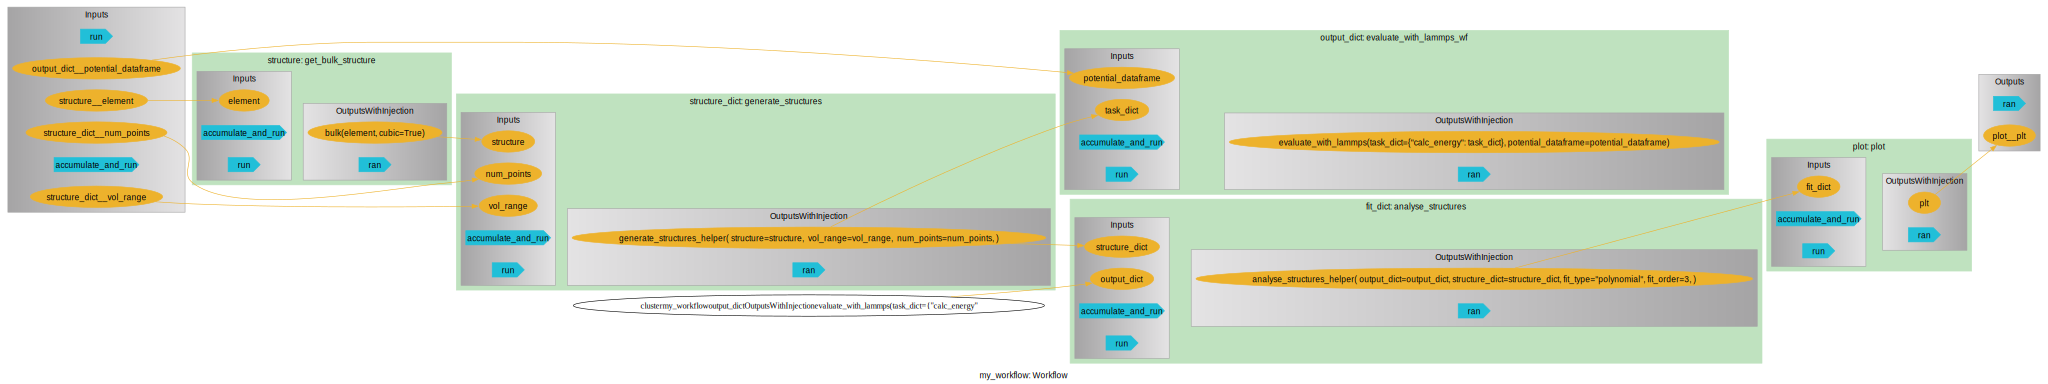

In [13]:
wf.draw()

{'plot__plt': <module 'matplotlib.pyplot' from '/Users/janssen/mambaforge/lib/python3.12/site-packages/matplotlib/pyplot.py'>}

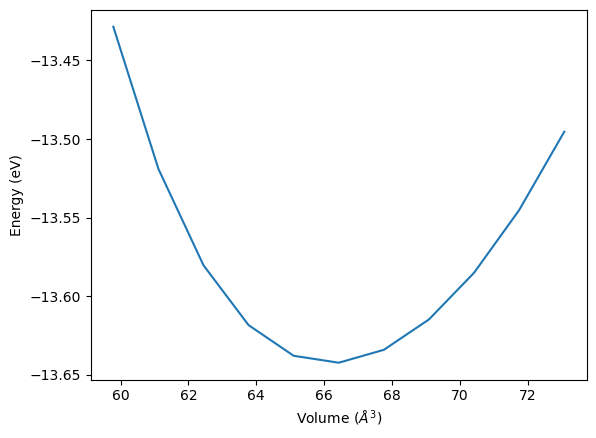

In [14]:
wf.run()